In [2]:
%load_ext autoreload
%autoreload 2

In [36]:
import matplotlib.pyplot as plt
import numpy as np
import torch

from torchdiffeq import odeint

from pideq.four_tanks import four_tanks
from pideq.net import PINN
from pideq.utils import load_from_wandb

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [38]:
net = load_from_wandb(PINN(20, n_nodes=20), '1977fz77', model_fname='model_best').to(device)
net.eval()

PINN(
  (fcn): Sequential(
    (0): Linear(in_features=1, out_features=20, bias=True)
    (1): Tanh()
    (2): Linear(in_features=20, out_features=20, bias=True)
    (3): Tanh()
    (4): Linear(in_features=20, out_features=20, bias=True)
    (5): Tanh()
    (6): Linear(in_features=20, out_features=20, bias=True)
    (7): Tanh()
    (8): Linear(in_features=20, out_features=20, bias=True)
    (9): Tanh()
    (10): Linear(in_features=20, out_features=4, bias=True)
  )
)

In [23]:
K = 200
dt = .1
time = [dt * k for k in range(K+1)]

y0 = torch.Tensor([12.6, 13.0, 4.8, 4.9]).unsqueeze(0)

u = torch.Tensor([3.15, 3.15]).unsqueeze(0)
u

y = odeint(lambda t, y: four_tanks(y,u), y0, torch.Tensor(time), method='rk4')
y = y.squeeze(1)
y.shape

torch.Size([201, 4])

In [39]:
x = torch.Tensor(time).unsqueeze(-1).to(device)
y_pred = net(x)
y_pred.shape

torch.Size([201, 4])

IAE =	66.568
MAE =	0.008


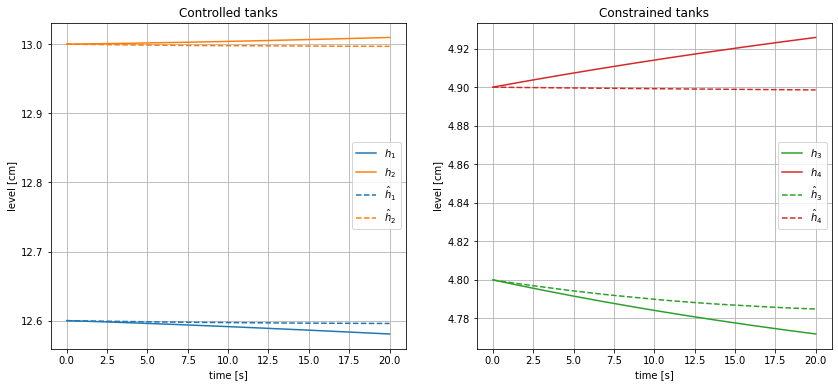

In [41]:
y_ = y.detach().numpy()
y_pred_ = y_pred.cpu().detach().numpy()

iae = np.abs(y_ - y_pred_).sum() / dt
mae = np.abs(y_ - y_pred_).mean()

print(f"IAE =\t{iae:.3f}")
print(f"MAE =\t{mae:.3f}")

fig, axs = plt.subplots(1,2)
fig.set_size_inches(14,6)

axs[0].set_title('Controlled tanks')
axs[0].plot(time, y_[:,0], c='tab:blue', label='$h_1$')
axs[0].plot(time, y_[:,1], c='tab:orange', label='$h_2$')
axs[0].plot(time, y_pred_[:,0], '--', c='tab:blue', label='$\hat{h}_1$')
axs[0].plot(time, y_pred_[:,1], '--', c='tab:orange', label='$\hat{h}_2$')
axs[0].set_ylabel('level [cm]')
axs[0].set_xlabel('time [s]')
axs[0].legend()
axs[0].grid()

axs[1].set_title('Constrained tanks')
axs[1].plot(time, y_[:,2], c='tab:green', label='$h_3$')
axs[1].plot(time, y_[:,3], c='tab:red', label='$h_4$')
axs[1].plot(time, y_pred_[:,2], '--', c='tab:green', label='$\hat{h}_3$')
axs[1].plot(time, y_pred_[:,3], '--', c='tab:red', label='$\hat{h}_4$')
axs[1].set_ylabel('level [cm]')
axs[1].set_xlabel('time [s]')
axs[1].legend()
axs[1].grid()

plt.show()

In [46]:
x = torch.Tensor(time).unsqueeze(-1).to(device)
x.requires_grad_()
y_pred = net(x)
y_pred.shape

torch.Size([201, 4])

In [47]:
Jy = four_tanks(y_pred, u.to(y_pred).repeat(y_pred.shape[0],1))

dy_i_preds = list()
for i in range(y_pred.shape[-1]):
    dy_i_preds.append(torch.autograd.grad(y_pred[:,-1].sum(), x, create_graph=True)[0])

Jy_pred = torch.stack(dy_i_preds, dim=-1).squeeze(1)